MASTER THESIS

Fire-hazard zone segmentation of aerial images on inter urban-rural
areas

Check use GPU

In [6]:
import tensorflow as tf
import keras
import sys
print("Python version:", sys.version)
print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.version.VERSION)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Python version: 3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]
Keras version: 2.10.0
Tensorflow version: 2.10.0
Num GPUs Available: 1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9



IMPORT

In [7]:
# IMPORT
import os
import cv2
import random
import shutil
import splitfolders
import numpy as np
import seaborn as sns
import segmentation_models as sm
from PIL import Image
from matplotlib import pyplot as plt
from patchify import patchify
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import to_categorical

SHOW DATA

In [8]:
# Function plot image and mask
def show_image_and_mask(image_path, mask_path):
    # Read the image and mask
    image_show = cv2.imread(image_path)
    mask_show = cv2.imread(mask_path)

    # Convert the image from BGR to RGB
    img_show_rgb = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB)

    # Create a figure to display the image and mask side by side
    plt.figure(figsize=(12, 8))

    # Display the image
    plt.subplot(121)
    plt.imshow(img_show_rgb)
    plt.title('Image')

    # Display the mask (assuming the mask is a single channel image)
    plt.subplot(122)
    plt.imshow(mask_show[:, :, 2], cmap='gray')  # Display the third channel of the mask
    plt.title('Mask')

    plt.show()

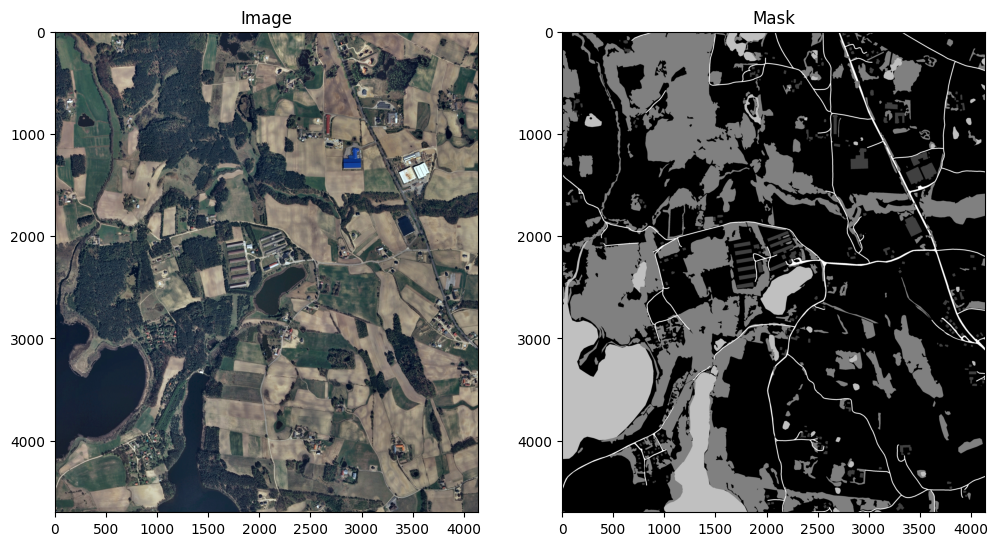

Label: 0 (Other), Pixels: 12467974
Label: 1 (Building), Pixels: 352837
Label: 2 (Woodland), Pixels: 4757764
Label: 3 (Water), Pixels: 1491426
Label: 4 (Road), Pixels: 373335


In [9]:
# Show data
img = cv2.imread("Land-cover_dataset/images/N-33-60-D-c-4-2.tif")
#plt.imshow(img)
mask = cv2.imread("Land-cover_dataset/masks/N-33-60-D-c-4-2.tif")
#plt.imshow(mask[:, :, 2])

image_path = "Land-cover_dataset/images/N-33-60-D-c-4-2.tif"
mask_path = "Land-cover_dataset/masks/N-33-60-D-c-4-2.tif"
show_image_and_mask(image_path, mask_path)

# Define label names
label_names = {
    0: "Other",
    1: "Building",
    2: "Woodland",
    3: "Water",
    4: "Road"
}

# Get unique labels and count pixels
labels, count_pixels = np.unique(mask[:, :, 2], return_counts=True)

# Print labels, names, and pixel counts
for label, count in zip(labels, count_pixels):
    label_name = label_names.get(label, "Unknown")
    print(f"Label: {label} ({label_name}), Pixels: {count}")


In [10]:
# Aggregates pixel counts for each unique label across all images
def aggregate_pixel_counts(mask_dir):
    # Initialize a dictionary to hold the aggregated pixel counts
    aggregated_counts = {}

    # Loop through each file in the mask directory
    for filename in os.listdir(mask_dir):
        if filename.endswith(".tif"):  # Ensure we are only processing .tif files
            # Read the image
            img_path = os.path.join(mask_dir, filename)
            img = cv2.imread(img_path)

            # Ensure the image was read properly
            if img is not None:
                # Extract the label channel (assuming it's the third channel, index 2)
                labels = img[:, :, 2]

                # Get the unique labels and their counts in the current image
                unique_labels, counts = np.unique(labels, return_counts=True)

                # Aggregate the counts into the aggregated_counts dictionary
                for label, count in zip(unique_labels, counts):
                    if label in aggregated_counts:
                        aggregated_counts[label] += count
                    else:
                        aggregated_counts[label] = count

    return aggregated_counts

In [11]:
# Plot aggregated counts
def plot_pixel_counts(aggregated_counts):
    # Define label names
    label_names = {
        0: "Other",
        1: "Building",
        2: "Woodland",
        3: "Water",
        4: "Road"
    }
    
    # Print the aggregated counts
    for label, count in aggregated_counts.items():
        label_name = label_names.get(label, "Unknown")
        print(f'Label {label} ({label_name}): {count} pixels')

    # Plot the results
    labels = list(aggregated_counts.keys())
    pixel_counts = list(aggregated_counts.values())

    plt.figure(figsize=(12, 8))
    plt.bar(labels, pixel_counts, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Pixel Count')
    plt.title('Pixel Count per Label in Land-cover Dataset')
    plt.xticks(labels, [label_names.get(label, "Unknown") for label in labels])  # Set x-ticks to be the label names
    plt.show()

Label 0 (Other): 1735888143 pixels
Label 1 (Building): 25546030 pixels
Label 2 (Woodland): 994881794 pixels
Label 3 (Water): 181608253 pixels
Label 4 (Road): 48340881 pixels


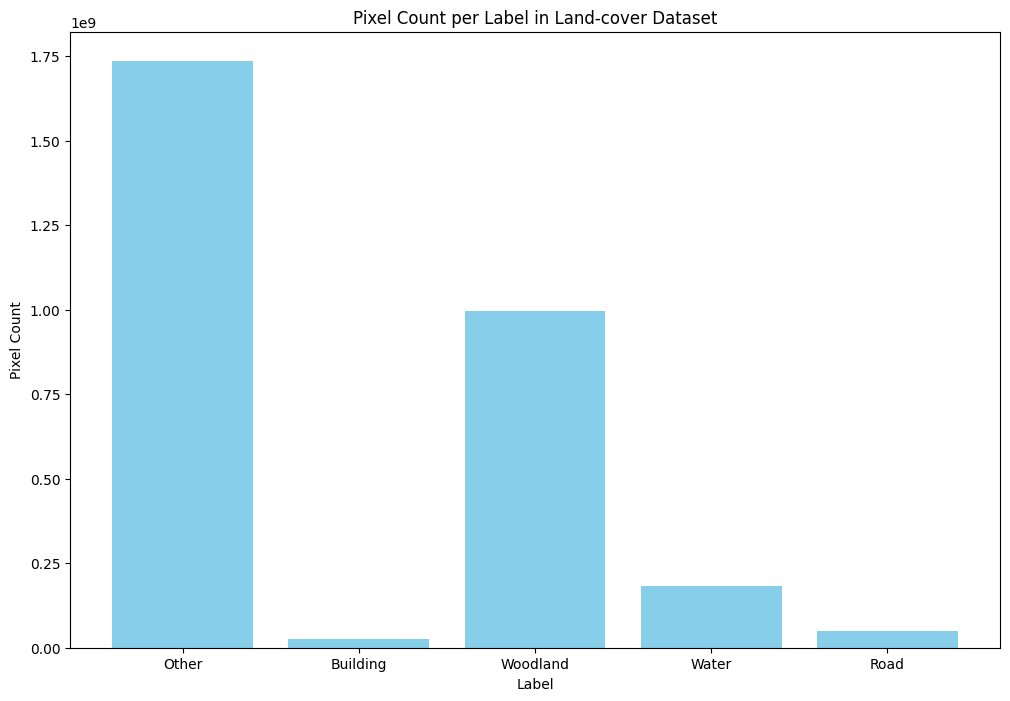

In [12]:
mask_dir = 'Land-cover_dataset/masks/'
aggregated_counts = aggregate_pixel_counts(mask_dir)
plot_pixel_counts(aggregated_counts)

MAIN PROGRAM

In [13]:
# Make directories
os.makedirs('Land-cover_dataset/256_patches/images/', True)
os.makedirs('Land-cover_dataset/256_patches/masks/', True)

In [14]:
# Crop image into patches of 256x256 and save them into a directory
patch_size = 256

def patch_image(data_types):  # data_types - images or masks
    type_path = os.path.join("Land-cover_dataset", data_types)
    # print(type_path) # Land-cover_dataset\images or Land-cover_dataset\masks
    # path - current directory path,
    # subdir - list of the names of the subdirectories in the current directory (not used here),
    # files - list of the names of the non-directory files in the current directory
    for path, subdir, files in os.walk(type_path):
        # print(path) # Land-cover_dataset/images/
        images = [f for f in files if f.endswith(".tif")]  # All files whose name ends with .tir
        # print(images)
        for image_name in images:
            image_path = os.path.join(type_path, image_name)
            # print(image_path)  # Example Land-cover_dataset/images/M-33-20-D-c-4-2.tif
            image = cv2.imread(image_path, 1)  # 1, because RGB
            # print(image.shape, image_name)
            if image is not None:
                # Calculate the nearest size divisible by patch_size
                image_height = (image.shape[1] // patch_size) * patch_size
                image_width = (image.shape[0] // patch_size) * patch_size
                # Converts the NumPy array to a PIL Image object (good for operations like cropping, resizing)
                image = Image.fromarray(image)
                # Crop the image to the calculated size from the top-left corner
                image = image.crop((0, 0, image_height, image_width))
                # Converts the PIL Image back to a NumPy array
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), patch_size)  # 3, because channel RGB
                output_dir = os.path.join("Land-cover_dataset", "256_patches", data_types)
                # print(output_dir) # Land-cover_dataset\256_patches\images
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch = patches_img[i, j, 0, :, :, :]  # (num_patches_x, num_patches_y, 1, patch_size,
                        # patch_size, num_channels)
                        patch_filename = f"{image_name}_patch_{i}_{j}.tif"
                        patch_filepath = os.path.join(output_dir, patch_filename)
                        cv2.imwrite(patch_filepath, single_patch)

In [15]:
patch_image("images")
patch_image("masks")

Show 256x256

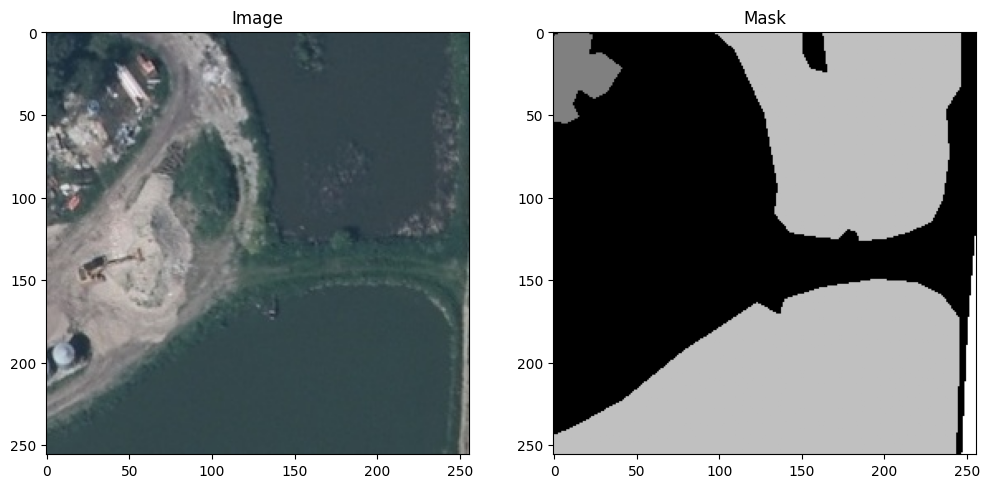

In [16]:
image_path = "Land-cover_dataset/256_patches/images/N-33-104-A-c-1-1.tif_patch_31_1.tif"
mask_path = "Land-cover_dataset/256_patches/masks/N-33-104-A-c-1-1.tif_patch_31_1.tif"
show_image_and_mask(image_path, mask_path)

REMOVE USELESS IMAGES

In [17]:
# Filter and copy images and masks and show labeles and count pixels after remove useless
def filter_and_copy_images_masks(train_images_dir, train_masks_dir):
    # Create directories for filtered images and masks
    os.makedirs('Land-cover_dataset/256_patches/images_with_useful_info/images/', exist_ok=True)
    os.makedirs('Land-cover_dataset/256_patches/images_with_useful_info/masks/', exist_ok=True)
    # REMOVE IT BELOW
    # os.makedirs('Land-cover_dataset/256_patches/images_with_useless_info/images/', exist_ok=True)
    # os.makedirs('Land-cover_dataset/256_patches/images_with_useless_info/masks/', exist_ok=True)

    img_list = os.listdir(train_images_dir)
    msk_list = os.listdir(train_masks_dir)
    useless = 0
    left_useless = 0

    # Filter and copy images and masks
    for img in range(len(img_list)):
        img_name = img_list[img]
        mask_name = msk_list[img]

        temp_image = cv2.imread(os.path.join(train_images_dir, img_name), 1)  # Read image
        temp_mask = cv2.imread(os.path.join(train_masks_dir, mask_name), 0)  # Read mask

        if temp_image is None or temp_mask is None:
            print(f"Error reading {img_name} or {mask_name}. Skipping these files.")
            continue

        val, counts = np.unique(temp_mask, return_counts=True)  # Get unique values and their counts in the mask

        if (1 - (counts[0] / counts.sum())) > 0.05:  # Check if more than 5% of the mask is not zero
            cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useful_info/images/', img_name),
                        temp_image)
            cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useful_info/masks/', mask_name),
                        temp_mask)
        else:
            useless += 1
            if useless % 200 == 0:
                left_useless += 1
                # REMOVE IT BELOW
                # cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useless_info/images/', img_name),
                #             temp_image)
                # cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useless_info/masks/', mask_name),
                #             temp_mask)
                cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useful_info/images/', img_name),
                            temp_image)
                cv2.imwrite(os.path.join('Land-cover_dataset/256_patches/images_with_useful_info/masks/', mask_name),
                            temp_mask)

    print("Total useful images are:", len(img_list) - useless)
    print("Total useless images are:", useless)
    print("Left useless images:", left_useless)

    # SHOW LABELS AND COUNT_PIXELS AFTER REMOVE USELESS
    aggregated_counts = aggregate_pixel_counts('Land-cover_dataset/256_patches/images_with_useful_info/masks')
    plot_pixel_counts(aggregated_counts)

SPLIT DATA to TRAINING AND VALIDATION

In [18]:
# Split data into training and validation sets
def split_data(input_folder, output_folder):
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

MOVE FILES FOR KERAS

In [19]:
# Move files for more organize
def move_files_for_organize(source_folder, destination_folder):
    # Create destination directories
    os.makedirs(destination_folder, exist_ok=True)
    for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
        os.makedirs(os.path.join(destination_folder, subdir), exist_ok=True)

    # Define subdirectories
    subdirs = ['train', 'val']
    for subdir in subdirs:
        # Move images
        src_images = os.path.join(source_folder, subdir, 'images')
        dst_images = os.path.join(destination_folder, f'{subdir}_images', subdir)
        for file_name in os.listdir(src_images):
            shutil.move(os.path.join(src_images, file_name), dst_images)

        # Move masks
        src_masks = os.path.join(source_folder, subdir, 'masks')
        dst_masks = os.path.join(destination_folder, f'{subdir}_masks', subdir)
        for file_name in os.listdir(src_masks):
            shutil.move(os.path.join(src_masks, file_name), dst_masks)

# REMOVE IT BELOW
    # # Move useless info files
    # useless_info_images_src = 'Land-cover_dataset/256_patches/images_with_useless_info/images/'
    # useless_info_masks_src = 'Land-cover_dataset/256_patches/images_with_useless_info/masks/'
    # useless_info_images_dst = os.path.join(destination_folder, 'useless_info/images/')
    # useless_info_masks_dst = os.path.join(destination_folder, 'useless_info/masks/')

    # os.makedirs(useless_info_images_dst, exist_ok=True)
    # os.makedirs(useless_info_masks_dst, exist_ok=True)

    # for file_name in os.listdir(useless_info_images_src):
    #     shutil.move(os.path.join(useless_info_images_src, file_name), useless_info_images_dst)

    # for file_name in os.listdir(useless_info_masks_src):
    #     shutil.move(os.path.join(useless_info_masks_src, file_name), useless_info_masks_dst)

Functions call

Total useful images are: 23143
Total useless images are: 20979
Left useless images: 104
Label 0 (Other): 759548545 pixels
Label 2 (Woodland): 588837264 pixels
Label 4 (Road): 45225700 pixels
Label 3 (Water): 105190601 pixels
Label 1 (Building): 24713282 pixels


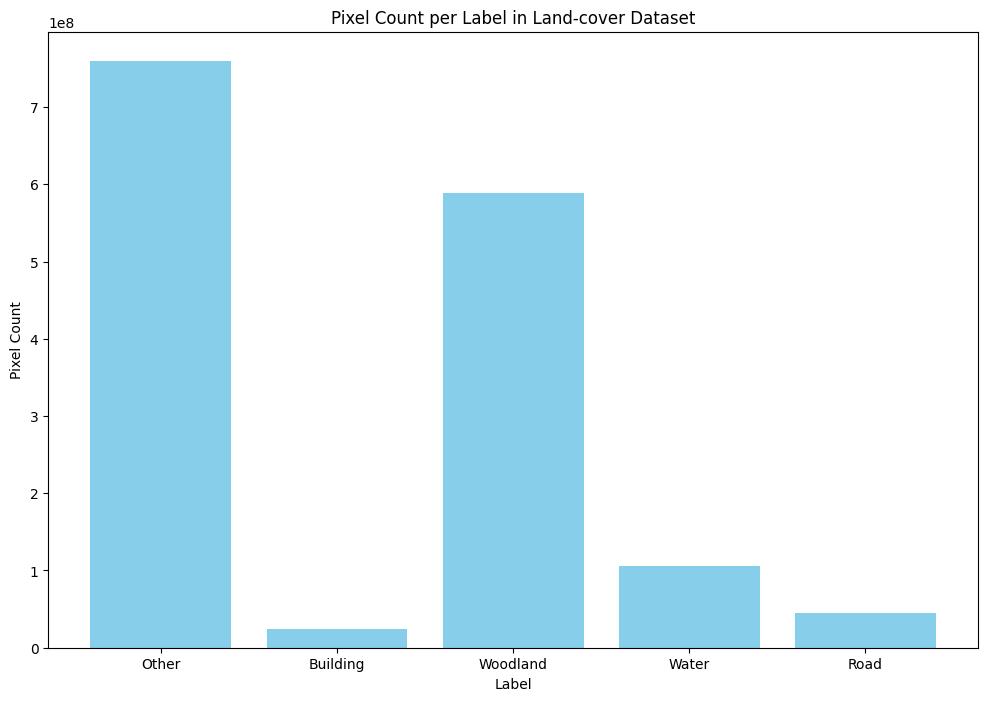

In [20]:
train_images_dir = "Land-cover_dataset/256_patches/images/"
train_masks_dir = "Land-cover_dataset/256_patches/masks/"
input_folder = 'Land-cover_dataset/256_patches/images_with_useful_info/'
output_folder = 'Land-cover_dataset/data_for_training_and_testing/'
destination_folder = 'Land-cover_dataset/keras_data/'

# Filter and copy images and masks
filter_and_copy_images_masks(train_images_dir, train_masks_dir)

# Split data into training and validation sets
split_data(input_folder, output_folder)

# Move files for organize
move_files_for_organize(output_folder, destination_folder)

GENERATOR

Parameters

In [21]:
# Set parameters
seed = 24
batch_size = 16
n_classes = 5

scaler = MinMaxScaler()
# Preprocessing function for the chosen backbone
preprocess_input = sm.get_preprocessing('resnet34')

Preprocess

In [22]:
# Function to preprocess images and masks
def preprocess_data(img, mask, num_class):
    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  # Preprocess based on the pretrained backbone
    # Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [23]:
# Define the generator.
def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        batch_size=batch_size,
        seed=seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode=None,
        color_mode='grayscale',
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, mask_generator)

    for img, mask in train_generator:
        #print(f'Image batch shape: {img.shape}')
        #print(f'Mask batch shape: {mask.shape}')
        img, mask = preprocess_data(img, mask, num_class)
        yield img, mask

TrainGenerator for TRAIN

In [24]:
# Define directories train
train_images_dir = "Land-cover_dataset/keras_data/train_images/"
train_masks_dir = "Land-cover_dataset/keras_data/train_masks/"

train_images_gen = trainGenerator(train_images_dir, train_masks_dir, num_class=n_classes)

TrainGenerator for VAL

In [25]:
# Define directories val
val_images_dir = "Land-cover_dataset/keras_data/val_images/"
val_masks_dir = "Land-cover_dataset/keras_data/val_masks/"

val_images_gen = trainGenerator(val_images_dir, val_masks_dir, num_class=n_classes)

In [26]:
def display_images_and_masks(images_gen, batch_type='train', num_images=4):
    # Fetch a batch of images and masks
    x_batch, y_batch = next(images_gen)
    
    # Print the shapes of the image and mask batches
    print(f'Sample {batch_type} image batch shape: {x_batch.shape}')
    print(f'Sample {batch_type} mask batch shape: {y_batch.shape}')
    
    # Display the specified number of images and masks
    for i in range(num_images):
        image = x_batch[i]
        mask = np.argmax(y_batch[i], axis=2)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f'{batch_type.capitalize()} Image {i+1}')
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{batch_type.capitalize()} Mask {i+1}')
        plt.show()

Found 17435 images belonging to 1 classes.
Found 17435 images belonging to 1 classes.
Sample train image batch shape: (16, 256, 256, 3)
Sample train mask batch shape: (16, 256, 256, 5)


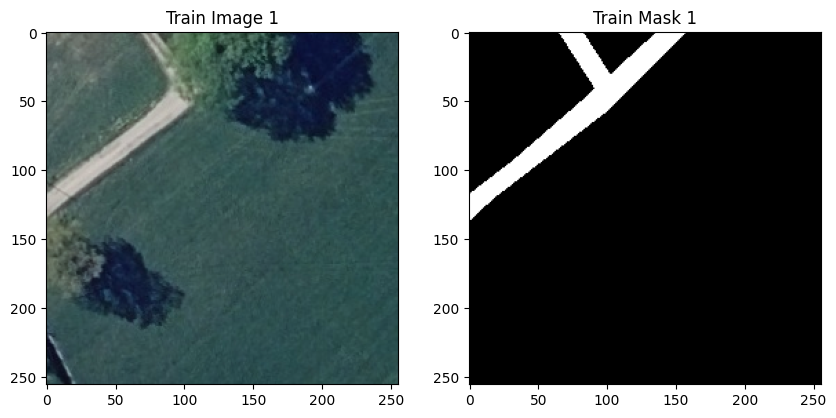

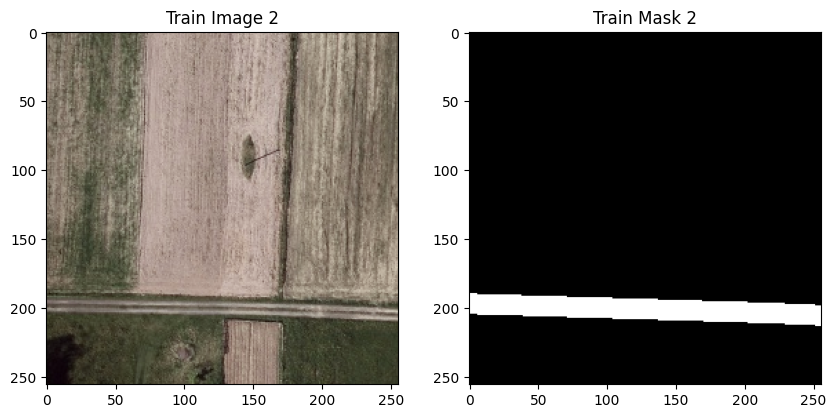

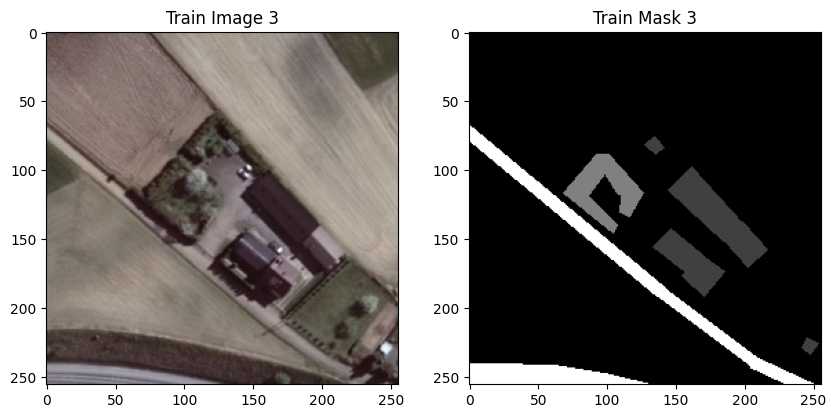

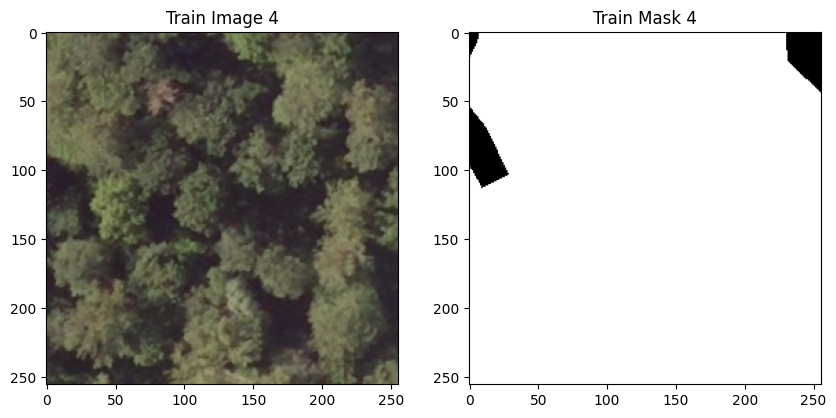

Found 5812 images belonging to 1 classes.
Found 5812 images belonging to 1 classes.
Sample val image batch shape: (16, 256, 256, 3)
Sample val mask batch shape: (16, 256, 256, 5)


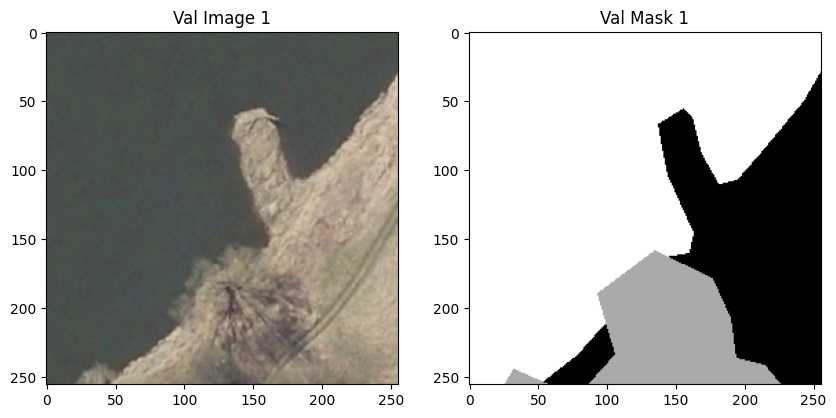

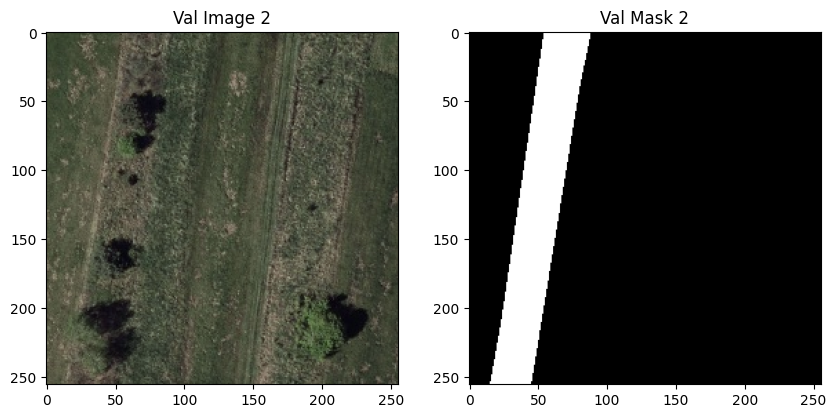

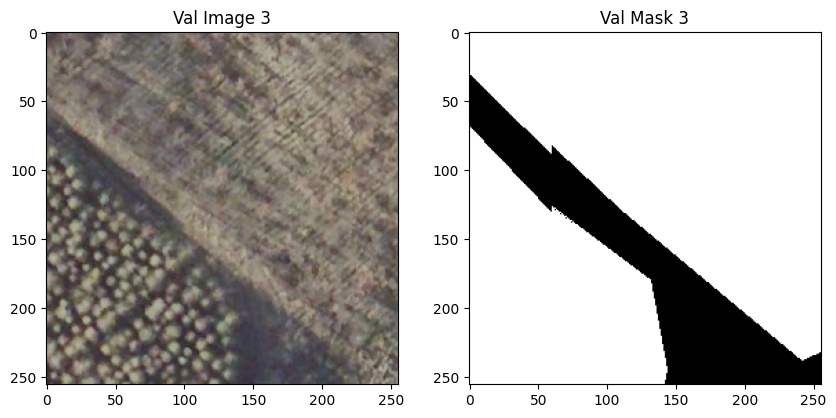

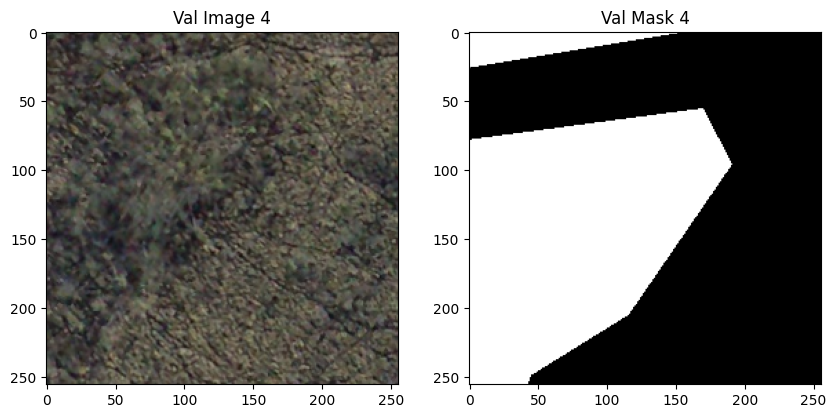

In [27]:
# Fetch a batch of images and masks train
display_images_and_masks(train_images_gen, batch_type='train')

# Fetch a batch of images and masks validation
display_images_and_masks(val_images_gen, batch_type='val')

MODEL

In [28]:
# Model metrcis
x_train, y_train = next(train_images_gen)

num_train_images = len(os.listdir('Land-cover_dataset/keras_data/train_images/train/'))
num_val_images = len(os.listdir('Land-cover_dataset/keras_data/val_images/val/'))

steps_per_epoch = num_train_images//batch_size
print("Train steps per epoch: " + str(steps_per_epoch))

val_steps_per_epoch = num_val_images//batch_size
print("Val steps per epoch: " + str(val_steps_per_epoch))

IMG_HEIGHT = x_train.shape[1]
IMG_WIDTH  = x_train.shape[2]
IMG_CHANNELS = x_train.shape[3]

print("Image height: " + str(IMG_HEIGHT))
print("Image width: " + str(IMG_WIDTH))
print("Image channels: " + str(IMG_CHANNELS))

Train steps per epoch: 1089
Val steps per epoch: 363
Image height: 256
Image width: 256
Image channels: 3


Define model

In [29]:
model = sm.Unet(
    'resnet34',
    encoder_weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    classes=n_classes,
    activation='softmax')

model.compile(
    'Adam',
    loss=sm.losses.categorical_focal_jaccard_loss,
    metrics=[sm.metrics.iou_score])

In [30]:
history=model.fit(
    train_images_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=25,
    verbose=1,
    validation_data=val_images_gen,
    validation_steps=val_steps_per_epoch)

model.save('landcover_1.hdf5')

Epoch 1/25
1089/1089 [==============================] - 326s 288ms/step - loss: 0.5665 - iou_score: 0.4726 - val_loss: 0.7526 - val_iou_score: 0.3164
Epoch 2/25
1089/1089 [==============================] - 280s 258ms/step - loss: 0.4742 - iou_score: 0.5608 - val_loss: 0.5007 - val_iou_score: 0.5391
Epoch 3/25
1089/1089 [==============================] - 279s 256ms/step - loss: 0.4370 - iou_score: 0.5951 - val_loss: 0.4309 - val_iou_score: 0.5992
Epoch 4/25
1089/1089 [==============================] - 278s 255ms/step - loss: 0.4134 - iou_score: 0.6166 - val_loss: 0.4224 - val_iou_score: 0.6088
Epoch 5/25
1089/1089 [==============================] - 288s 264ms/step - loss: 0.3942 - iou_score: 0.6340 - val_loss: 0.4052 - val_iou_score: 0.6273
Epoch 6/25
1089/1089 [==============================] - 558s 512ms/step - loss: 0.3858 - iou_score: 0.6419 - val_loss: 0.4321 - val_iou_score: 0.5973
Epoch 7/25
1089/1089 [==============================] - 555s 510ms/step - loss: 0.3823 - iou_score: 

Graph after model training

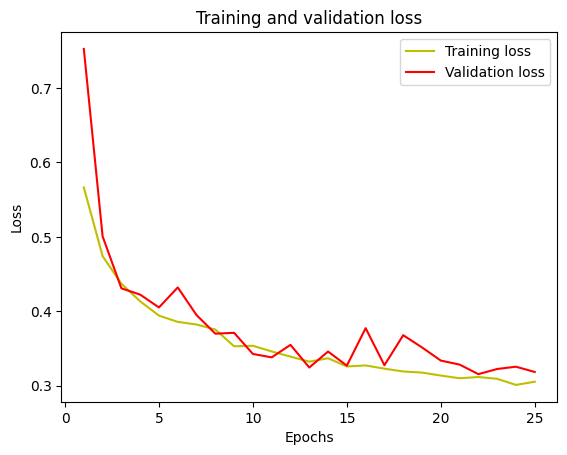

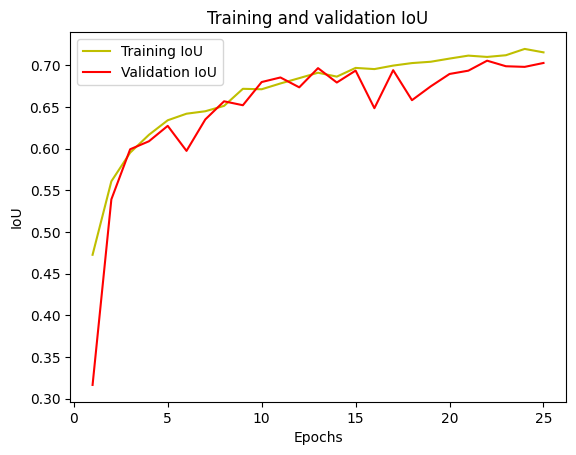

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score'] # Intersection over Union (IoU)
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

1/1 [==============================] - 1s 766ms/step


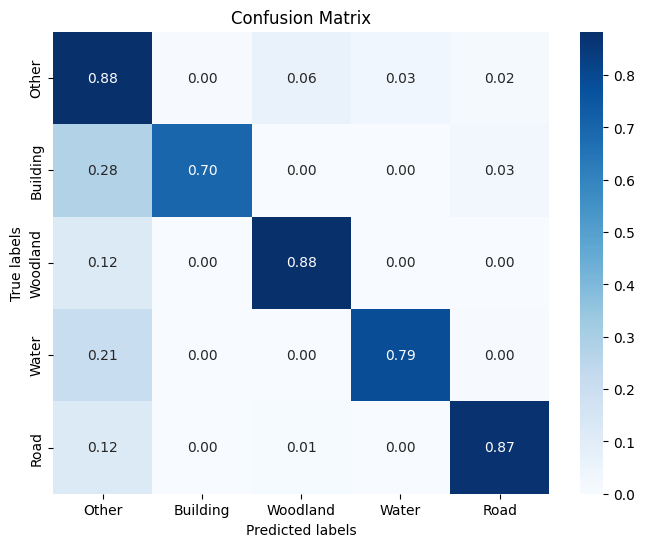

Mean IoU = 0.7280973


In [181]:
# Load the pre-trained model without compiling it
model = load_model("landcover_1.hdf5", compile=False)

# Generate a batch of test images and corresponding masks from the validation generator
test_image_batch, test_mask_batch = val_images_gen.__next__()

# Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Compute confusion matrix
n_classes = 5
cm = confusion_matrix(test_mask_batch_argmax.flatten(), test_pred_batch_argmax.flatten(), labels=range(n_classes), normalize='true')

# Define class labels
classes = ['Other', 'Building', 'Woodland', 'Water', 'Road']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Initialize the MeanIoU metric with the number of classes
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

FINAL RESULT

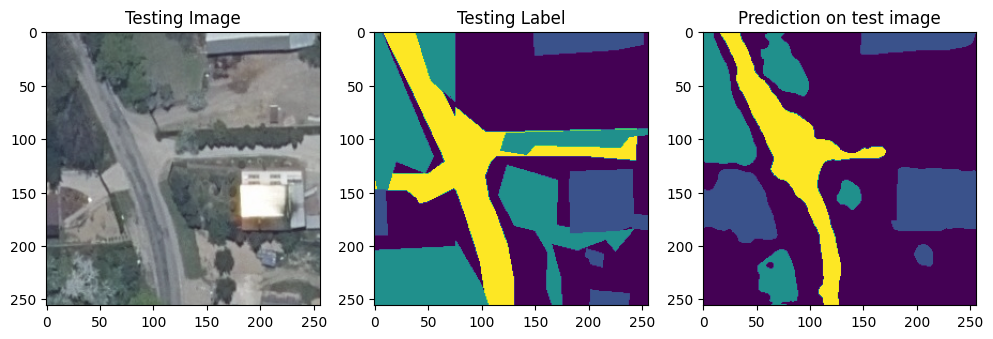

In [169]:
# Randomly select an image index from the test batch
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()